In [2]:
import numpy as np 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
import cv2 as cv
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
import cv2 
from tqdm import tqdm
import os



Using TensorFlow backend.


In [4]:
traindf=pd.read_csv("C:\\Users\\Rupam Kajal\\Desktop\\Dance Form\\dataset\\train.csv")
testdf=pd.read_csv("C:\\Users\\Rupam Kajal\\Desktop\\Dance Form\\dataset\\test.csv")


In [5]:
traindf.head()

,Image,target
0,96.jpg,manipuri
1,163.jpg,bharatanatyam
2,450.jpg,odissi
3,219.jpg,kathakali
4,455.jpg,odissi


In [6]:
testdf.head()


,Image
0,508.jpg
1,246.jpg
2,473.jpg
3,485.jpg
4,128.jpg


In [7]:
# to check any null values in the dataset
for col in traindf.columns:
    if traindf[col].isnull().values.any():
        print(f"Train Dataset Feature - {col} contains {traindf[col].isna().sum()*100/traindf[col].sum()}% of Null Values")
    
for col in testdf.columns:
    if testdf[col].isnull().values.any():
        print(f"Test Dataset Feature - {col} contains {testdf[col].isna().sum()*100/testdf[col].sum()}% of Null Values")

mohiniyattam     50
odissi           49
kathakali        47
bharatanatyam    47
kuchipudi        46
sattriya         45
kathak           44
manipuri         36
Name: target, dtype: int64


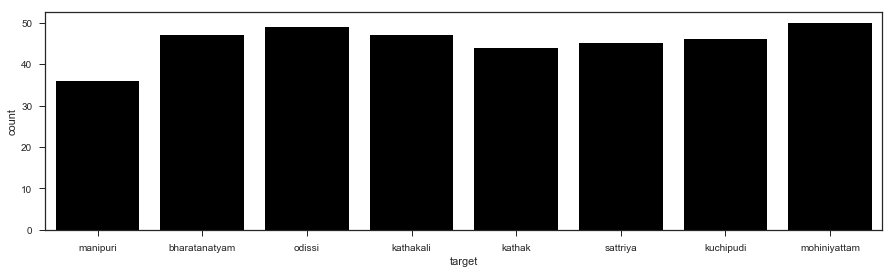

In [8]:
print(traindf["target"].value_counts())

sns.set_style('ticks')
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(15, 4)
sns.countplot(traindf["target"],color='black')

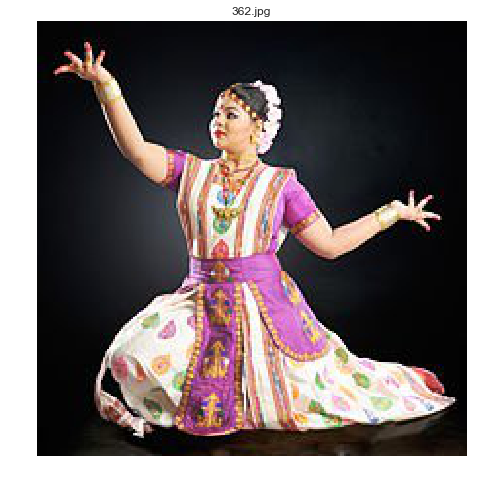

In [9]:
train_path = 'C:\\Users\\Rupam Kajal\\Desktop\\Dance Form\\dataset\\train'

path = f'{train_path}'    
fig = plt.figure(figsize = (13, 8))
image = cv.imread(path + f'/362.jpg')
plt.imshow(image[:, :, ::-1])
plt.title("362.jpg")
plt.axis('off')
plt.show()

In [10]:
class_names =np.unique(traindf['target'])
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)
print(class_names)
print(class_names_label)

['bharatanatyam' 'kathak' 'kathakali' 'kuchipudi' 'manipuri'
 'mohiniyattam' 'odissi' 'sattriya']
{'bharatanatyam': 0, 'kathak': 1, 'kathakali': 2, 'kuchipudi': 3, 'manipuri': 4, 'mohiniyattam': 5, 'odissi': 6, 'sattriya': 7}


In [15]:
IMAGE_SIZE = (150, 150)
dataset = train_path
output = []
train_images = []
train_labels = []
for files in tqdm(os.listdir(dataset)):
    try:
        label=class_names_label[traindf.loc[traindf['Image'] == files]['target'].values[0]]
    except:
        #do nothing
        a=1
    img_path=os.path.join(dataset, files)
    # Open and resize the img
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, IMAGE_SIZE) 
    # Append the image and its corresponding label to the output
    train_images.append(image)
    train_labels.append(label)

100%|██████████| 364/364 [00:04<00:00, 78.36it/s] 


In [17]:
IMAGE_SIZE = (150, 150)
dataset ="C:\\Users\\Rupam Kajal\\Desktop\\Dance Form\\dataset\\test"  

output = []
test_images = []
for files in tqdm(os.listdir(dataset)):
    img_path=os.path.join(dataset, files)
    # Open and resize the img
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, IMAGE_SIZE) 
    # Append the image and its corresponding label to the output
    test_images.append(image)

100%|██████████| 156/156 [00:01<00:00, 79.63it/s] 


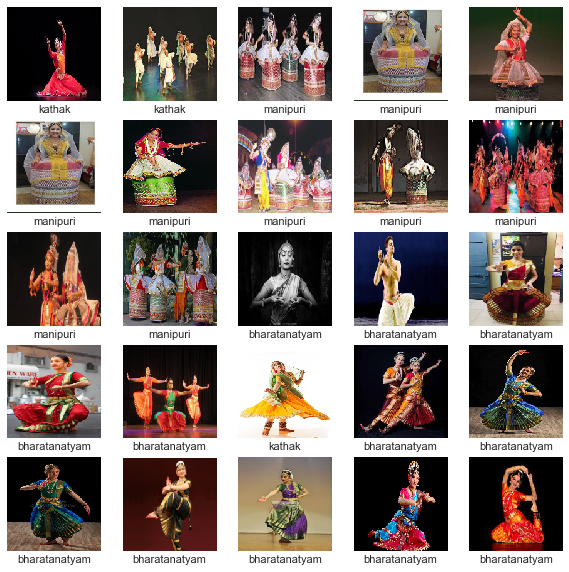

In [18]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [19]:
train_images = np.array(train_images, dtype = 'float32')
test_images = np.array(test_images, dtype = 'float32')
train_labels = np.array(train_labels, dtype = 'int32') 

In [20]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val=train_test_split(train_images,train_labels,test_size=0.3)


In [21]:
# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = test_images.astype('float32') / 255

In [22]:
y_train = keras.utils.to_categorical(y_train, len(class_names))
y_val = keras.utils.to_categorical(y_val, len(class_names))

In [23]:
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_val shape:', x_val.shape)
print('y_val shape:', y_val.shape)

x_train shape: (254, 150, 150, 3)
y_train shape: (254, 8)
x_val shape: (110, 150, 150, 3)
y_val shape: (110, 8)


In [24]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [25]:
datagen.fit(x_train)

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense,MaxPooling2D,Dropout
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf

image_size = x_train.shape[1]
inputshape = (image_size, image_size, 3)
batchsize = 128
kernel_size = 3
pool_size = 3
filters = 64
dropout = 0.2
epochs=50

model = Sequential([
        Conv2D(filters=filters, input_shape=inputshape, kernel_size=kernel_size,activation='relu', name='conv_1'),
        MaxPooling2D(pool_size=(4, 4), name='pool_1'),
        Dropout(dropout),
        Conv2D(filters=64, kernel_size=kernel_size, activation='relu', name='conv_2'),
        MaxPooling2D(pool_size=(4, 4), name='pool_2'),
        Dropout(dropout),
        Flatten(name='flatten'),
        Dense(units=256, activation='relu', name='dense_1'),
        Dense(units=8, activation='softmax', name='dense_2')
    ])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 37, 37, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 37, 37, 64)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 35, 35, 64)        36928     
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0

In [28]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy','mae'])
early_stopping_callback = EarlyStopping(monitor='val_loss')
model_name="Conv2D_basic"
checkpoint_callback = ModelCheckpoint(model_name+'.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history=model.fit(datagen.flow(x_train, y_train, batch_size=batchsize), epochs=epochs, callbacks=[early_stopping_callback, checkpoint_callback],validation_data=(x_val, y_val))


Epoch 1/50
1/2 [==============>...............] - ETA: 2s - loss: 2.2571 - acc: 0.1406 - mean_absolute_error: 0.2186
Epoch 00001: val_loss improved from inf to 110.94157, saving model to Conv2D_basic.h5
2/2 [==============================] - 6s 3s/step - loss: 2.8602 - acc: 0.1142 - mean_absolute_error: 0.2197 - val_loss: 110.9416 - val_acc: 0.1455 - val_mean_absolute_error: 0.2135
Epoch 2/50
1/2 [==============>...............] - ETA: 1s - loss: 2.5728 - acc: 0.1825 - mean_absolute_error: 0.2121
Epoch 00002: val_loss improved from 110.94157 to 46.67828, saving model to Conv2D_basic.h5
2/2 [==============================] - 6s 3s/step - loss: 2.4508 - acc: 0.1890 - mean_absolute_error: 0.2142 - val_loss: 46.6783 - val_acc: 0.1182 - val_mean_absolute_error: 0.2177
Epoch 3/50
1/2 [==============>...............] - ETA: 1s - loss: 2.1866 - acc: 0.1641 - mean_absolute_error: 0.2178
Epoch 00003: val_loss improved from 46.67828 to 17.62984, saving model to Conv2D_basic.h5
2/2 [==============

In [29]:
df=pd.DataFrame(history.history)
df.head()

,acc,loss,mean_absolute_error,val_acc,val_loss,val_mean_absolute_error
0,0.114173,2.857021,0.219668,0.145455,110.941574,0.213458
1,0.188976,2.450164,0.214169,0.118182,46.678280,0.217670
2,0.161417,2.124013,0.217163,0.100000,17.629839,0.222250
3,0.181102,2.064633,0.217879,0.118182,7.537247,0.217382
4,0.185039,2.063457,0.218162,0.145455,4.718952,0.214792


[Text(0,0.5,'Loss'), Text(0.5,0,'Epoch')]

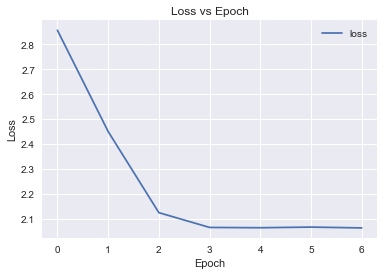

In [30]:
loss_plot=df.plot(y="loss",title="Loss vs Epoch")
loss_plot.set(xlabel="Epoch",ylabel="Loss")

In [31]:
loss,accuracy,mae=model.evaluate(x_val,y_val)
print(loss)
print(accuracy*100)
print(mae)

110/110 [==============================] - 0s 3ms/sample - loss: 4.2467 - acc: 0.1273 - mean_absolute_error: 0.2147
4.246680597825484
12.727272510528564
0.21466056


In [32]:
pred=model.predict(x_test)

In [33]:
prediction=np.argmax(pred, axis = 1)

In [34]:
prediction

array([2, 5, 7, 6, 6, 2, 2, 6, 2, 7, 5, 6, 7, 2, 2, 2, 5, 5, 3, 2, 5, 3,
       2, 2, 2, 7, 2, 2, 5, 6, 2, 6, 2, 7, 7, 2, 2, 7, 2, 2, 2, 2, 2, 2,
       2, 2, 7, 5, 3, 2, 5, 5, 7, 5, 5, 5, 2, 5, 5, 7, 5, 2, 5, 2, 5, 5,
       5, 5, 5, 7, 2, 2, 5, 5, 3, 5, 5, 2, 2, 6, 2, 7, 7, 2, 5, 5, 2, 2,
       6, 5, 2, 2, 5, 2, 2, 2, 7, 2, 7, 7, 7, 2, 5, 3, 5, 6, 2, 5, 2, 2,
       6, 5, 2, 6, 5, 7, 2, 2, 2, 2, 2, 7, 7, 2, 2, 2, 7, 2, 2, 2, 2, 5,
       3, 2, 7, 2, 2, 7, 3, 7, 7, 2, 5, 6, 5, 6, 2, 2, 5, 5, 2, 6, 3, 6,
       7, 3], dtype=int64)

In [35]:
data = pd.DataFrame(prediction,columns=["values"])

In [36]:
dow = {
    0:"bharatanatyam",
    1:"kathak",
    2:"kathakali",
    3:"kuchipudi", 
    4:"manipuri", 
    5:"mohiniyattam", 
    6:"odissi",
    7:"sattriya"
}

data["dow"] = data['values'].map(dow)

In [37]:
ImageName = np.array(testdf["Image"])
prediction = np.array(data["dow"])
submission_dataset = pd.DataFrame({'Image': ImageName, 'target': prediction}, columns=['Image', 'target'])
submission_dataset.to_csv('C:\\Users\\Rupam Kajal\\Desktop\\Dance Form\\dataset\\submission_Initial.csv', header=True, index=False) 